<a id="top"></a>
# Water Observations from Space (WOFS) <img align="right" style="padding:10px" src="../images/odc_logo.png">

This notebook demonstrates the Australian Water Observations from Space (WOFS) algorithm. This water detection algorithm is significantly better than the Landsat QA water flag or the NDWI index for water identification. 

For more information, visit this website:
http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

import datetime
import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr
import pandas as pd

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

In [2]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = "ls7_ledaps_kenya"
# platform = "LANDSAT_7"

product = "ls8_lasrc_kenya"
platform = "LANDSAT_8"

# product = "ls8_lasrc_ghana"
# platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [3]:
# Print extents of the Data Cube
extents = api.get_full_dataset_extent(platform = platform, product = product)

latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))

print(latitude_extents)
print(longitude_extents)
print(time_extents)

(-4.997106940467012, 5.996881030410326)
(32.98674340708594, 41.9828951536269)
(numpy.datetime64('2013-04-12T07:50:21.000000000'), numpy.datetime64('2020-01-19T07:42:56.000000000'))


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [4]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Be sure you check whether you are using L7 or L8 as the time extents are very different
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the water assessment

# Mombasa, Kenya
# latitude_extents = (-4.0475, -3.9574) 
# longitude_extents = (39.6028, 39.6792) 
# time_extents = ('2015-01-01', '2018-01-01')

# Naivasha, Kenya
# latitude_extents = (-0.8509, -0.66) 
# longitude_extents = (36.246, 36.47) 
# time_extents = ('2014-01-01', '2018-01-01')

# Ndakaini Dam, Kenya (provides water to Nairobi)
latitude_extents =  (-0.8270, -0.8067) 
longitude_extents =  (36.8137, 36.8529)
time_extents = ('2016-01-01', '2019-01-01')

In [5]:
# The code below renders a map that can be used to view the analysis region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>
After loading, you will view the Xarray dataset. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [6]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [7]:
# View some of the content in the xarray dataset
# The latitude and longitude dimensions are in pixels
# The time reflects the number of time slices in the xarray
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 76, longitude: 146, time: 43)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-08T07:43:14 ... 2017-12-28T07:43:21
  * latitude   (latitude) float64 -0.8067 -0.807 -0.8073 ... -0.8268 -0.8271
  * longitude  (longitude) float64 36.81 36.81 36.81 36.81 ... 36.85 36.85 36.85
Data variables:
    red        (time, latitude, longitude) int16 324 336 325 341 ... 265 307 339
    green      (time, latitude, longitude) int16 680 707 682 645 ... 446 490 530
    blue       (time, latitude, longitude) int16 187 193 191 200 ... 178 203 226
    nir        (time, latitude, longitude) int16 5505 5404 5349 ... 3863 4331
    swir1      (time, latitude, longitude) int16 1823 1809 1816 ... 1555 1667
    swir2      (time, latitude, longitude) int16 676 675 692 721 ... 546 657 718
    pixel_qa   (time, latitude, longitude) int32 322 322 322 322 ... 322 322 322
Attributes:
    crs:      EPSG:4326

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)

In [9]:
cloud_mask = np.bitwise_and(landsat_dataset.pixel_qa,6).astype(bool)
cleaned_dataset = landsat_dataset.drop('pixel_qa').where(cloud_mask)

## <span id="time_series_water">Time Series Water Detection Analysis [&#9652;](#top)</span>
Time series output of the Australian Water Observations from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

In [10]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
ts_water_classification = wofs_classify(landsat_dataset,clean_mask = cloud_mask.values)

In [11]:
# Apply nan to no_data values
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999).astype(np.float16)

# Time series aggregation that ignores nan values.    
water_classification_percentages = (ts_water_classification.mean(dim = ['time']) * 100).wofs.rename('water_classification_percentages')

In [12]:
# import color-scheme and set nans to black
from matplotlib.cm import jet_r
jet_r.set_bad('black',1)

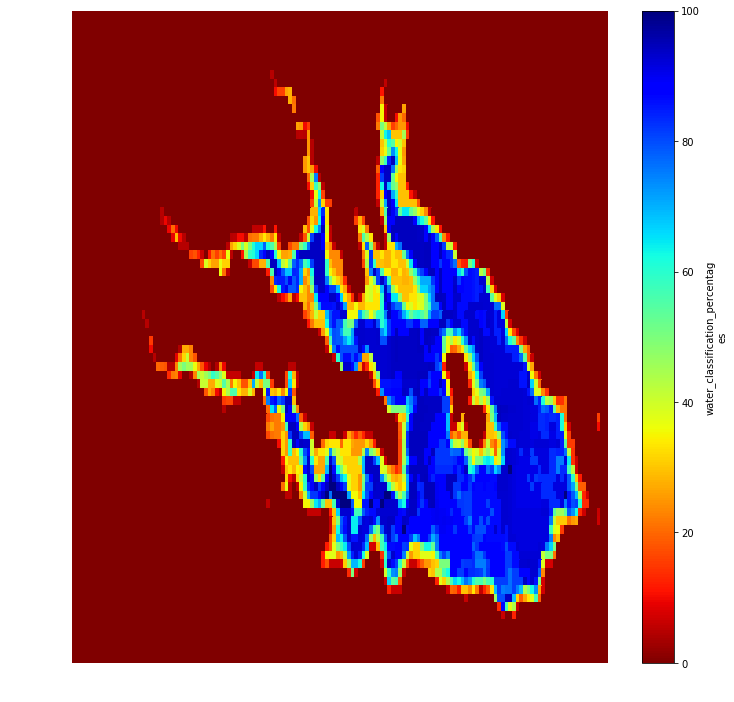

In [13]:
# This is where the WOFS time series product is generated. 
# Areas of RED have experienced little or no water over the time series
# Areas of BLUE have experience significant or constant water over the time series

# The "figsize" may need adjustment to get the proper scaling and avoid distortion. 
# See the XARRAY dimensions above to get an idea of the Lat-Lon ratio for your image, figsize=(x,y)
# The y-axis scale and legend is part of the image area, so that needs to be considered
# It is suggested to keep the x-dimension at x=12. 

water_classification_percentages.plot(cmap = jet_r, figsize=(12,12))
plt.axis('off')
plt.show()

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

In [14]:
# Save the water percentage image to a GeoTIFF
from utils.data_cube_utilities.import_export import export_slice_to_geotiff
dataset_to_export = xr.Dataset(coords=water_classification_percentages.coords,attrs=ts_water_classification.attrs)
dataset_to_export['wofs_pct'] = (water_classification_percentages/100).astype(np.float32)

In [15]:
# The export command on the following line is commented out to avoid overwriting files. 
# If you would like to export data, please change the filename before uncommenting the next line.

# export_slice_to_geotiff(dataset_to_export, 'geotiffs/sample_WOFS.tif')

In [16]:
# !ls -lah geotiffs/